The basemap regridding tutorial that this is based upon is located at: http://earthpy.org/interpolation_between_grids_with_pyresample.html

In [1]:
# plotting stuff
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cartopy.crs as crs

# built in python modules
import datetime
import os
import inspect
import sys

# python add-ons
import numpy as np
import pandas as pd
import scipy
import xarray as xr
import netCDF4
from wrf import (to_np, getvar, ALL_TIMES, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)
import pyresample as prs
import optwrf as ow
from optwrf import runwrf as rw

/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/pvlib-python/pvlib/wrfcast.py:20: UserWarning: The forecast module algorithms and features are highly experimental. The API may change, the functionality may be consolidated into an io module, or the module may be separated into its own package.
  'The forecast module algorithms and features are highly experimental. '


In [2]:
param_ids = [10, 1, 1, 2, 2, 3, 2]
start_date = 'Feb 7  2011'
end_date = 'Feb 8 2011'
wrf_sim = rw.WRFModel(param_ids, start_date, end_date, 
                      setup_yaml='/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/met4ene/optwrf/optwrf/data/mac_dirpath.yml') 

Forecast starting on: 2011-02-07 00:00:00
Forecast ending on: 2011-02-08 00:00:00


In [3]:
# Find the path to optwrf
optwrf_path = os.path.dirname(os.path.abspath(inspect.getfile(ow)))

In [4]:
in_yr = 2011
in_mo = 2
wrfdir = os.path.join(optwrf_path, 'data/')
eradir = wrf_sim.DIR_ERA5_ROOT

In [5]:
# WRF file containing source grid
wrffile = 'wrfout_processed_d01.nc'
try:
    wrfdata = xr.open_dataset(wrfdir + wrffile)
except FileNotFoundError:
    print(f'The wrfout file {wrfdir + wrffile} does not exist. Check that your path.')

# Get wrf variable(s) to regrid
# wrf_lat = wrfdata.XLAT
# wrf_lon = wrfdata.XLONG
# wrfdata = wrfdata.rename({'XLONG': 'lon', 'XLAT': 'lat'})

# Read in and convert GHI from W m-2 to kW m-2
wrfdata['ghi'] = wrfdata.ghi / 1000

# Read in WPD, convert from W m-2 to kW m-2
wrfdata['wpd'] = wrfdata.wpd / 1000

wrfdata

<xarray.Dataset>
Dimensions:         (Time: 24, bottom_top: 35, south_north: 191, west_east: 191)
Coordinates:
  * Time            (Time) datetime64[ns] 2011-02-07 ... 2011-02-07T23:00:00
    lon             (south_north, west_east) float32 ...
    lat             (south_north, west_east) float32 ...
    wspd_wdir       object ...
    XLONG           (south_north, west_east) float32 ...
    XLAT            (south_north, west_east) float32 ...
    XTIME           (Time) float32 ...
    level           int64 ...
Dimensions without coordinates: bottom_top, south_north, west_east
Data variables:
    Times           (Time) datetime64[ns] ...
    temp_air        (Time, south_north, west_east) float32 ...
    wind_speed_u    (Time, south_north, west_east) float32 ...
    wind_speed_v    (Time, south_north, west_east) float32 ...
    cloud_fraction  (Time, bottom_top, south_north, west_east) float32 ...
    cos_zenith      (Time, south_north, west_east) float32 ...
    dni             (Time, south_north, west_east) float32 ...
    dhi             (Time, south_north, west_east) float32 ...
    ghi             (Time, south_north, west_east) float32 0.0 0.0 ... 0.0 0.0
    wind_speed10    (Time, south_north, west_east) float32 ...
    wind_speed100   (Time, south_north, west_east) float32 ...
    wpd             (Time, south_north, west_east) float32 29.141006 ... 7.67...

In [6]:
# ERA data file(s)
erafile = f'ERA5_EastUS_WPD-GHI_{str(in_yr).zfill(4)}-{str(in_mo).zfill(2)}.nc'
try:
    eradata = xr.open_dataset(eradir + erafile)
except FileNotFoundError:
    # Process the ERA5 data
    wrf_sim.process_era5_data()

# Get variables to compare with regridded WRF variables.
# era_lat = eradata.latitude
# era_lon = eradata.longitude
eradata = eradata.rename({'longitude': 'lon', 'latitude': 'lat'})

# Read in ERA_GHI, convert from W m-2 to kW m-2
era_ghi = eradata.GHI
era_ghi = era_ghi / 1000

# Read in ERA_WPD, convert from W m-2 to kW m-2
era_wpd = eradata.WPD
era_wpd = era_wpd / 1000

# Write these back to the xarray dataset
eradata['ghi'] = era_ghi
eradata['wpd'] = era_wpd

eradata = eradata.sortby('lat', ascending=True)

eradata

<xarray.Dataset>
Dimensions:   (Time: 1056, lat: 97, lon: 129)
Coordinates:
  * Time      (Time) datetime64[ns] 2011-01-16T06:00:00 ... 2011-03-01T05:00:00
  * lat       (lat) float64 28.0 28.25 28.5 28.75 29.0 ... 51.25 51.5 51.75 52.0
  * lon       (lon) float64 264.0 264.2 264.5 264.8 ... 295.2 295.5 295.8 296.0
Data variables:
    VAR_100U  (Time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    VAR_100V  (Time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    WPD       (Time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    SSRD      (Time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    GHI       (Time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ghi       (Time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    wpd       (Time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan

In [7]:
# SwathDefinition() require that lons and lats be in a specific format (taken care of by check_and_wrap())
# and that they have the same shape (taken care of by np.meshgrid())
era_lon, era_lat = prs.utils.check_and_wrap(eradata.lon.values, eradata.lat.values)
era_lon2d, era_lat2d = np.meshgrid(era_lon, era_lat)

In [8]:
# Create the definition for the target (ERA5 lat/lon) grid
era_def = prs.geometry.SwathDefinition(lons=era_lon2d, lats=era_lat2d)

In [9]:
# Preprocess and create the definition for the source (WRF Lambert Conformal) grid
wrf_lon, wrf_lat = prs.utils.check_and_wrap(wrfdata.lon.values, wrfdata.lat.values)
wrf_def = prs.geometry.SwathDefinition(lons=wrf_lon, lats=wrf_lat)

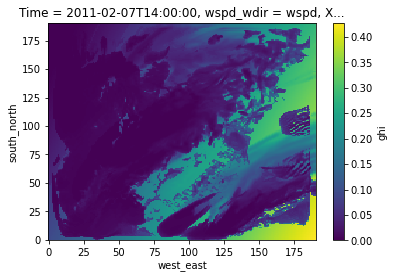

In [10]:
# Extract a single time slice for regridding -- pyresample works with numpy not xarray
idx = 14
timestr = wrfdata.Time[idx]
wrf_ghi_slice = wrfdata.ghi.sel(Time=timestr)
wrf_ghi_slice.plot()

In [11]:
# Regrid with a simple nearest neighbor algorithm 
wrf_ghi_nearest = prs.kd_tree.resample_nearest(wrf_def, wrf_ghi_slice.values, \
        era_def, radius_of_influence=25000, fill_value=None)

In [12]:
# Regrid with a custom weight function -- inverse of the distance
wf = lambda r: 1/r**2
wrf_ghi_idw = prs.kd_tree.resample_custom(wrf_def, wrf_ghi_slice.values, \
                           era_def, radius_of_influence=25000, neighbours=100,\
                           weight_funcs=wf, fill_value=None)

/Users/swardy9230/opt/anaconda3/envs/optwrf/lib/python3.7/site-packages/matplotlib/image.py:475: RuntimeWarning: overflow encountered in true_divide
  A_scaled /= ((a_max - a_min) / 0.8)


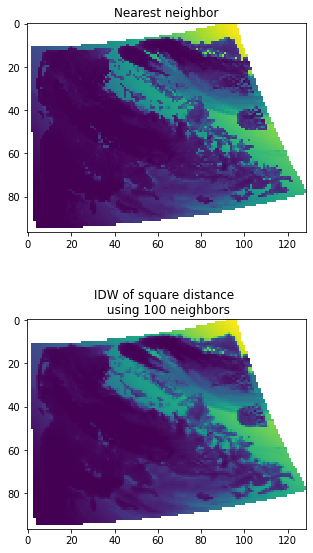

In [13]:
# Visualize both methods of regridding
fig = plt.figure(figsize=(5,10))

ax = fig.add_subplot(211)
ax.imshow(wrf_ghi_nearest,interpolation='nearest')
ax.set_title("Nearest neighbor")

ax = fig.add_subplot(212)
ax.imshow(wrf_ghi_idw,interpolation='nearest')
plt.title("IDW of square distance \n using 100 neighbors");

In [14]:
# Put result into an xarray DataArray
da = xr.DataArray(wrf_ghi_nearest, dims=("lat", "lon"), coords={"lat": era_lat, "lon": era_lon})
# Transform the latitude coordinate back to [0-360]
da.coords['lon'] = (da.coords['lon'] % 360)
# Add a time dimension
da.coords['Time'] = timestr.values
da = da.expand_dims("Time")
da

<xarray.DataArray (Time: 1, lat: 97, lon: 129)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 28.0 28.25 28.5 28.75 29.0 ... 51.25 51.5 51.75 52.0
  * lon      (lon) float64 264.0 264.2 264.5 264.8 ... 295.2 295.5 295.8 296.0
  * Time     (Time) datetime64[ns] 2011-02-07T14:00:00

In [15]:
first = True
for timestr in wrfdata.Time:
    # Select the time slice from xarray
    wrf_ghi_slice = wrfdata.ghi.sel(Time=timestr)
    # Regrid with a nearest neighbor algorithm 
    ghi_regrid = prs.kd_tree.resample_nearest(wrf_def, wrf_ghi_slice.values, \
                 era_def, radius_of_influence=25000, fill_value=None)
    # Put result into an xarray DataArray
    wrf_ghi_regrid_slice = xr.DataArray(ghi_regrid, dims=("lat", "lon"), coords={"lat": era_lat, "lon": era_lon})
    # Transform the latitude coordinate back to [0-360]
    wrf_ghi_regrid_slice.coords['lon'] = (wrf_ghi_regrid_slice.coords['lon'] % 360)
    # Add a time dimension
    wrf_ghi_regrid_slice.coords['Time'] = timestr.values
    wrf_ghi_regrid_slice = wrf_ghi_regrid_slice.expand_dims("Time")
    if first is True:
        wrf_ghi_regrid = wrf_ghi_regrid_slice
        first = False
    else:
        wrf_ghi_regrid = xr.concat([wrf_ghi_regrid, wrf_ghi_regrid_slice], 'Time')

wrf_ghi_regrid

<xarray.DataArray (Time: 24, lat: 97, lon: 129)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 28.0 28.25 28.5 28.75 29.0 ... 51.25 51.5 51.75 52.0
  * lon      (lon) float64 264.0 264.2 264.5 264.8 ... 295.2 295.5 295.8 296.0
  * Time     (Time) datetime64[ns] 2011-02-07 ... 2011-02-07T23:00:00

In [16]:
# Now do everything above within a time loop within a function...
def prs_nearest_regrid(data, var, source_def, target_def, target_lat, target_lon):
    first = True
    for timestr in data.Time:
        # Select the time slice from xarray
        data_slice = data[var].sel(Time=timestr)
        # Regrid with a nearest neighbor algorithm 
        regridded_data_slice = prs.kd_tree.resample_nearest(source_def, data_slice.values, \
                     target_def, radius_of_influence=25000, fill_value=None)
        # Put result into an xarray DataArray
        regridded_data_slice_da = xr.DataArray(regridded_data_slice, dims=('lat', 'lon'), coords={'lat': target_lat, 'lon': target_lon})
        # Transform the latitude coordinate back to [0-360]
        regridded_data_slice_da.coords['lon'] = (regridded_data_slice_da.coords['lon'] % 360)
        # Add a time dimension
        regridded_data_slice_da.coords['Time'] = timestr.values
        regridded_data_slice_da = regridded_data_slice_da.expand_dims('Time')
        if first is True:
            regridded_data = regridded_data_slice_da
            first = False
        else:
            regridded_data = xr.concat([regridded_data, regridded_data_slice_da], 'Time')

    return regridded_data

In [17]:
# Do the regridding
wrf_ghi_regrid = prs_nearest_regrid(wrfdata, 'ghi', wrf_def, era_def, era_lat, era_lon)
wrf_wpd_regrid = prs_nearest_regrid(wrfdata, 'wpd', wrf_def, era_def, era_lat, era_lon)

In [18]:
# Add the regridded variables to the WRF xarray dataset
wrfdata['ghi_regrid'] = wrf_ghi_regrid
wrfdata['wpd_regrid'] = wrf_wpd_regrid

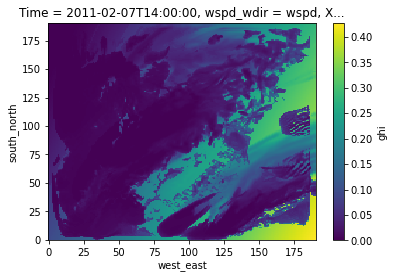

In [19]:
ghi2d = wrfdata.ghi.isel(Time=14)
ghi2d.plot()

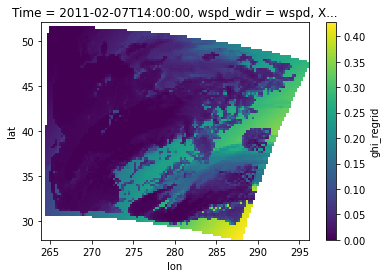

In [20]:
ghi2d = wrfdata.ghi_regrid.isel(Time=14)
ghi2d.plot()

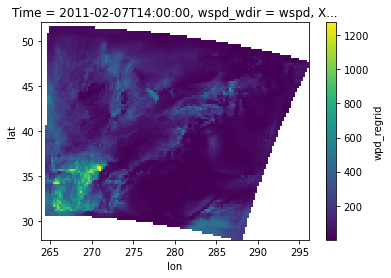

In [21]:
wrf_wpd_regrid
wpd2d = wrfdata.wpd_regrid.isel(Time=14)
wpd2d.plot()

In [22]:
# Get the total error now using the function in optwrf.runwrf
wrfdata = rw.wrf_era5_error(wrfdata, eradata)
wrfdata

<xarray.Dataset>
Dimensions:          (Time: 24, bottom_top: 35, lat: 97, lon: 129, south_north: 191, west_east: 191)
Coordinates:
  * Time             (Time) datetime64[ns] 2011-02-07 ... 2011-02-07T23:00:00
  * lon              (lon) float64 264.0 264.2 264.5 264.8 ... 295.5 295.8 296.0
  * lat              (lat) float64 28.0 28.25 28.5 28.75 ... 51.5 51.75 52.0
    wspd_wdir        <U4 'wspd'
    XLONG            (south_north, west_east) float32 -95.43335 ... -64.11832
    XLAT             (south_north, west_east) float32 30.952759 ... 47.507103
    XTIME            (Time) float32 0.0 60.0 120.0 ... 1260.0 1320.0 1380.0
    level            int64 100
Dimensions without coordinates: bottom_top, south_north, west_east
Data variables:
    Times            (Time) datetime64[ns] 2011-02-07 ... 2011-02-07T23:00:00
    temp_air         (Time, south_north, west_east) float32 ...
    wind_speed_u     (Time, south_north, west_east) float32 ...
    wind_speed_v     (Time, south_north, west_east) float32 ...
    cloud_fraction   (Time, bottom_top, south_north, west_east) float32 ...
    cos_zenith       (Time, south_north, west_east) float32 ...
    dni              (Time, south_north, west_east) float32 ...
    dhi              (Time, south_north, west_east) float32 ...
    ghi              (Time, south_north, west_east) float32 0.0 0.0 ... 0.0 0.0
    wind_speed10     (Time, south_north, west_east) float32 ...
    wind_speed100    (Time, south_north, west_east) float32 ...
    wpd              (Time, south_north, west_east) float32 29.141006 ... 7.6...
    ghi_regrid       (Time, lat, lon) float32 nan nan nan nan ... nan nan nan
    wpd_regrid       (Time, lat, lon) float32 nan nan nan nan ... nan nan nan
    ghi_error        (Time, lat, lon) float32 nan nan nan nan ... nan nan nan
    wpd_error        (Time, lat, lon) float32 nan nan nan nan ... nan nan nan
    total_ghi_error  (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    total_wpd_error  (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan

# Test that pyresample gives similar results to xesmf

In [23]:
# Now test the function that does the same as the above in optwrf.runwrf
wrfdata_2, eradata_2 = rw.wrf_era5_regrid_xesmf(in_yr, in_mo, wrfdir, eradir)

Create weight file: bilinear_9658590307
Remove file bilinear_9658590307


/Users/swardy9230/opt/anaconda3/envs/optwrf/lib/python3.7/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


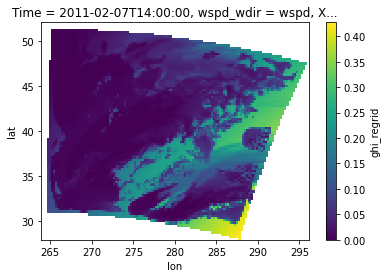

In [24]:
ghi2d = wrfdata_2.ghi_regrid.isel(Time=14)
ghi2d.plot()

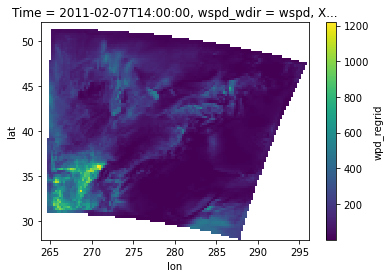

In [25]:
wrf_wpd_regrid
wpd2d = wrfdata_2.wpd_regrid.isel(Time=14)
wpd2d.plot()

In [26]:
# Get the total error now using the function in optwrf.runwrf
wrfdata_2 = rw.wrf_era5_error(wrfdata_2, eradata_2)
wrfdata_2

<xarray.Dataset>
Dimensions:          (Time: 24, bottom_top: 35, lat: 97, lon: 129, south_north: 191, west_east: 191)
Coordinates:
  * Time             (Time) datetime64[ns] 2011-02-07 ... 2011-02-07T23:00:00
  * lon              (lon) float64 264.0 264.2 264.5 264.8 ... 295.5 295.8 296.0
  * lat              (lat) float64 52.0 51.75 51.5 51.25 ... 28.5 28.25 28.0
    wspd_wdir        object ...
    XLONG            (south_north, west_east) float32 ...
    XLAT             (south_north, west_east) float32 ...
    XTIME            (Time) float32 ...
    level            int64 ...
Dimensions without coordinates: bottom_top, south_north, west_east
Data variables:
    Times            (Time) datetime64[ns] ...
    temp_air         (Time, south_north, west_east) float32 ...
    wind_speed_u     (Time, south_north, west_east) float32 ...
    wind_speed_v     (Time, south_north, west_east) float32 ...
    cloud_fraction   (Time, bottom_top, south_north, west_east) float32 ...
    cos_zenith       (Time, south_north, west_east) float32 ...
    dni              (Time, south_north, west_east) float32 ...
    dhi              (Time, south_north, west_east) float32 ...
    ghi              (Time, south_north, west_east) float32 0.0 0.0 ... 0.0 0.0
    wind_speed10     (Time, south_north, west_east) float32 ...
    wind_speed100    (Time, south_north, west_east) float32 ...
    wpd              (Time, south_north, west_east) float32 29141.006 ... 767...
    ghi_regrid       (Time, lat, lon) float64 nan nan nan nan ... nan nan nan
    wpd_regrid       (Time, lat, lon) float64 nan nan nan nan ... nan nan nan
    ghi_error        (Time, lat, lon) float64 nan nan nan nan ... nan nan nan
    wpd_error        (Time, lat, lon) float64 nan nan nan nan ... nan nan nan
    total_ghi_error  (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    total_wpd_error  (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

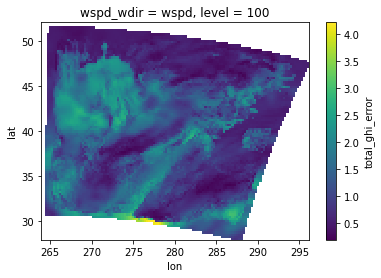

In [27]:
wrfdata.total_ghi_error.plot()

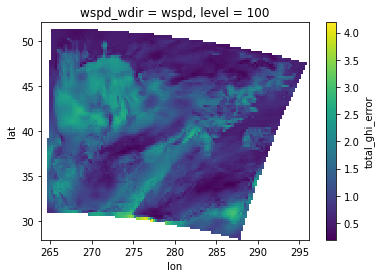

In [28]:
wrfdata_2.total_ghi_error.plot()

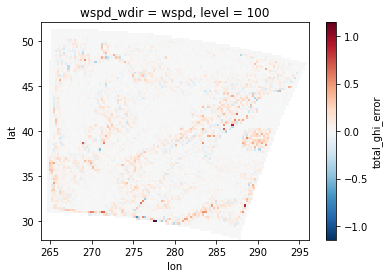

In [29]:
pyresample_xesmf_compare = wrfdata.total_ghi_error - wrfdata_2.total_ghi_error
pyresample_xesmf_compare.plot()

In [36]:
print(f'The total difference is: {abs(pyresample_xesmf_compare).sum().values} W m-2 day-1 or {abs(pyresample_xesmf_compare.sum().values/wrfdata_2.total_ghi_error.sum().values * 100} %')

The total difference is: 361.9162703064697 W m-2 day-1 or 1.5682718591414224 %
